IRTM Project 2
Partu Ana-Maria
507

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
import re
plt.style.use('ggplot')

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, BatchNormalization, Dropout, LSTM, Embedding, GlobalMaxPool1D
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Read data from the 2 cvs files into Pandas Dataframes. "Lyrics-Genre-Training.csv"is used for training and "Lyrics-Genre-Test-GroundTruth.csv" is used for testing.

In [3]:
df = pd.read_csv('Lyrics-Genre-Train.csv')
df2 = pd.read_csv('Lyrics-Genre-Test-GroundTruth.csv')

In [4]:
df.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260


In [5]:
df.shape

(18513, 6)

Next, only the relevant data is saved into new dataframes for both the training data and the test data.

In [6]:
#put relevant data into another dataframe
data = pd.DataFrame(columns=['Genre'])
data['Genre'] = df['Genre']
data['Lyrics'] = df['Lyrics']
data.head()

,Genre,Lyrics
0,Metal,"I am a night in to the darkness, only soul los..."
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ..."
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...
3,Hip-Hop,You know what? I'm destined to be the last man...
4,Country,There ain't nothing that I would rather see\nT...


In [7]:
test = pd.DataFrame(columns=['Genre'])
test['Genre'] = df2['Genre']
test['Lyrics'] = df2['Lyrics']

The data is labeled based on the "Genre" column. In order to improve accuracy similar genres were labeled the same in a new column of the dataset.
Country and Folk are labeled 0.
Electronic and Pop are labeled 1.
Hip-Hop is labeled 2.
Indie is labeled 3.
Jazz and R&B are labeled 4.
Metal and Rock are labeled 5.
A version of the code for all genres labeled as different classes was tested and the results are in the "Results.docx" document attached.

In [8]:
data['label'] = 0
for index, row in data.iterrows():
    data.loc[(data['Genre'] == 'Country'), 'label'] = 0
    data.loc[(data['Genre'] == 'Electronic'), 'label'] = 1
    data.loc[(data['Genre'] == 'Folk'), 'label'] = 0
    data.loc[(data['Genre'] == 'Hip-Hop'), 'label'] = 2
    data.loc[(data['Genre'] == 'Indie'), 'label'] = 3
    data.loc[(data['Genre'] == 'Jazz'), 'label'] = 4
    data.loc[(data['Genre'] == 'Metal'), 'label'] = 5
    data.loc[(data['Genre'] == 'Pop'), 'label'] = 1
    data.loc[(data['Genre'] == 'R&B'), 'label'] = 4
    data.loc[(data['Genre'] == 'Rock'), 'label'] = 5

In [9]:
data.head()

,Genre,Lyrics,label
0,Metal,"I am a night in to the darkness, only soul los...",5
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",2
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,5
3,Hip-Hop,You know what? I'm destined to be the last man...,2
4,Country,There ain't nothing that I would rather see\nT...,0


In [10]:
test['label'] = 0
for index, row in test.iterrows():
    test.loc[(test['Genre'] == 'Country'), 'label'] = 0
    test.loc[(test['Genre'] == 'Electronic'), 'label'] = 1
    test.loc[(test['Genre'] == 'Folk'), 'label'] = 0
    test.loc[(test['Genre'] == 'Hip-Hop'), 'label'] = 2
    test.loc[(test['Genre'] == 'Indie'), 'label'] = 3
    test.loc[(test['Genre'] == 'Jazz'), 'label'] = 4
    test.loc[(test['Genre'] == 'Metal'), 'label'] = 5
    test.loc[(test['Genre'] == 'Pop'), 'label'] = 1
    test.loc[(test['Genre'] == 'R&B'), 'label'] = 4
    test.loc[(test['Genre'] == 'Rock'), 'label'] = 5

In [11]:
test.head()

,Genre,Lyrics,label
0,Hip-Hop,Most folks spend their days daydreaming of fin...,2
1,Indie,Take your cold hands and put them on my face\n...,3
2,Metal,Are you ready it's time for war\nWe'll break d...,5
3,Pop,You ask me why I change the color of my hair\n...,1
4,Hip-Hop,Do you believe in magic in a young girl's hear...,2


The distribution of samples per class can be seen below.

In [12]:
country = data[data['label']==0]
pop = data[data['label']==1]
hiphop = data[data['label']==2]
indie = data[data['label']==3]
jazz = data[data['label']==4]
rock = data[data['label']==5]
print(country.shape)
print(pop.shape)
print(hiphop.shape)
print(indie.shape)
print(jazz.shape)
print(rock.shape)


(3043, 3)
(4130, 3)
(2240, 3)
(1190, 3)
(2730, 3)
(5180, 3)


e:\nlp2\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

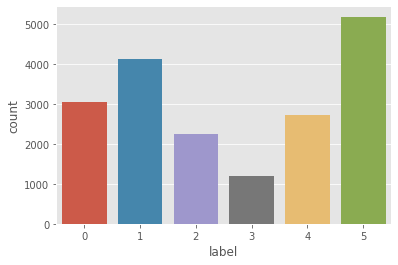

In [13]:
sns.countplot('label',data=data)

The data is then cleaned. A few specific sets of characters were removed after observation of the text. Lowercasing was applied as well as removal of numbers and special characters. Stopword were then removed and the text was lemmatized. the clean version of the text was added into a new column of the dataframe. 

In [14]:
clean = []
stop_words = stopwords.words('english')
stop_words.append('chorus')
stop_words.append('verse')
lemmatizer = WordNetLemmatizer()

In [15]:
for index, row in data.iterrows():
    lyrics = row['Lyrics']
    lyrics = re.sub('\n', "", lyrics)
    lyrics = re.sub('x1', "", lyrics)
    lyrics = re.sub('x2', "", lyrics)
    lyrics = re.sub('x3', "", lyrics)
    lyrics = re.sub('x4', "", lyrics)
    lyrics = re.sub('x5', "", lyrics)
    lyrics = re.sub('x6', "", lyrics)
    lyrics = re.sub('x7', "", lyrics)
    lyrics = re.sub('x8', "", lyrics)
    lyrics = re.sub('x9', "", lyrics)
    lyrics = lyrics.lower() #lowercasing
    lyrics = re.sub("[^a-z]+", " ", lyrics) #remove all numbers and special chars
    lyrics = lyrics.split()
    lyrics = [word for word in lyrics if not word in stop_words] #remove stopwords
    lyrics = [lemmatizer.lemmatize(token) for token in lyrics] #lemmatize
    lyrics = [lemmatizer.lemmatize(token, "v") for token in lyrics]
    lyrics = " ".join(lyrics)
    clean.append(lyrics)
data['new'] = clean #add clean tweets to a new column in the dataframe


In [16]:
data.head()

,Genre,Lyrics,label,new
0,Metal,"I am a night in to the darkness, only soul los...",5,night darkness soul lose walk throught thenigh...
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",2,yeahsometimes wanna fly away say skate surf st...
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,5,work hard work hard chicago work hard try hard...
3,Hip-Hop,You know what? I'm destined to be the last man...,2,know destine last man standincarefully mappin ...
4,Country,There ain't nothing that I would rather see\nT...,0,nothing would rather seethan dry docki think g...


In [17]:
clean = []
for index, row in test.iterrows():
    lyrics = row['Lyrics']
    lyrics = re.sub('\n', "", lyrics)
    lyrics = re.sub('x1', "", lyrics)
    lyrics = re.sub('x2', "", lyrics)
    lyrics = re.sub('x3', "", lyrics)
    lyrics = re.sub('x4', "", lyrics)
    lyrics = re.sub('x5', "", lyrics)
    lyrics = re.sub('x6', "", lyrics)
    lyrics = re.sub('x7', "", lyrics)
    lyrics = re.sub('x8', "", lyrics)
    lyrics = re.sub('x9', "", lyrics)
    lyrics = lyrics.lower() #lowercasing
    lyrics = re.sub("[^a-z]+", " ", lyrics) #remove all numbers and special chars
    lyrics = lyrics.split()
    lyrics = [word for word in lyrics if not word in stop_words] #remove stopwords
    lyrics = [lemmatizer.lemmatize(token) for token in lyrics] #lemmatize
    lyrics = [lemmatizer.lemmatize(token, "v") for token in lyrics]
    lyrics = " ".join(lyrics)
    clean.append(lyrics)
test['new'] = clean #add clean tweets to a new column in the dataframe


In [18]:
test.head()

,Genre,Lyrics,label,new
0,Hip-Hop,Most folks spend their days daydreaming of fin...,2,folk spend day daydream find cluesmy whole lif...
1,Indie,Take your cold hands and put them on my face\n...,3,take cold hand put facesharpen axe criminal wa...
2,Metal,Are you ready it's time for war\nWe'll break d...,5,ready time warwe break fuck doorssmash window ...
3,Pop,You ask me why I change the color of my hair\n...,1,ask change color hair yeah ask need thirty two...
4,Hip-Hop,Do you believe in magic in a young girl's hear...,2,believe magic young girl hearthow music free w...


data_copy=data
data_copy.head()

Wordclouds were use to visualize the word frequency of each class.

In [20]:
country = ' '.join(data[data.label == 0].new.values)
pop = ' '.join(data[data.label == 1].new.values)
hiphop = ' '.join(data[data.label == 2].new.values)
indie = ' '.join(data[data.label == 3].new.values)
jazz = ' '.join(data[data.label == 4].new.values)
rock = ' '.join(data[data.label == 5].new.values)

Text(0.5, 1.0, 'Country')

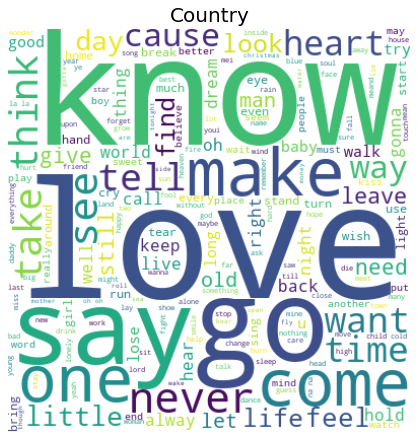

In [21]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(country)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Country', size=20)

Text(0.5, 1.0, 'Pop')

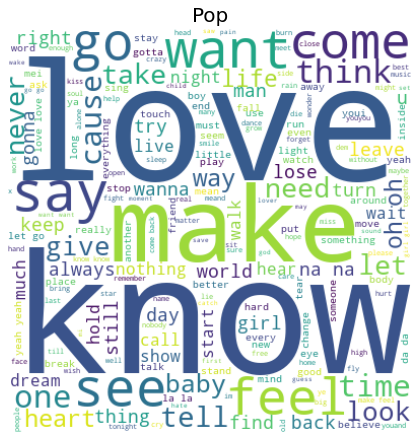

In [22]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(pop)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Pop', size=20)

Text(0.5, 1.0, 'Hip Hop')

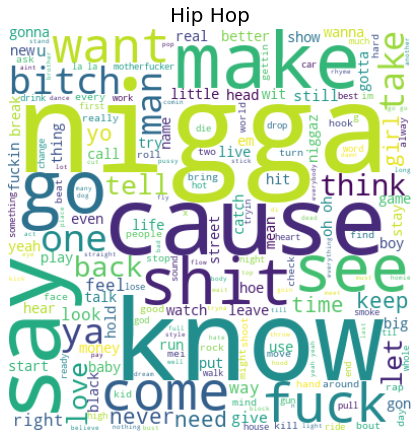

In [24]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(hiphop)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Hip Hop', size=20)

Text(0.5, 1.0, 'Jazz')

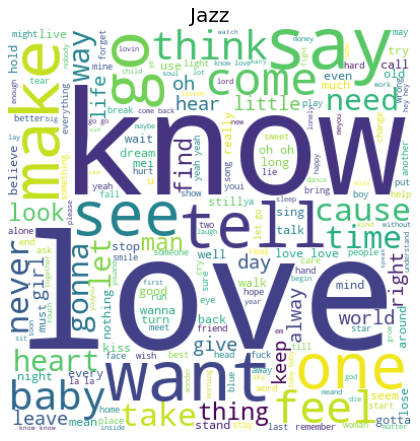

In [25]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(jazz)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Jazz', size=20)

Text(0.5, 1.0, 'Indie')

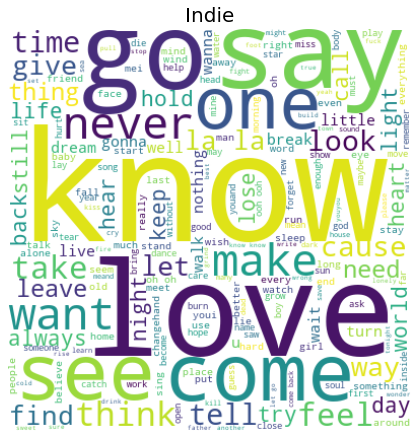

In [27]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(indie)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Indie', size=20)

Text(0.5, 1.0, 'Rock')

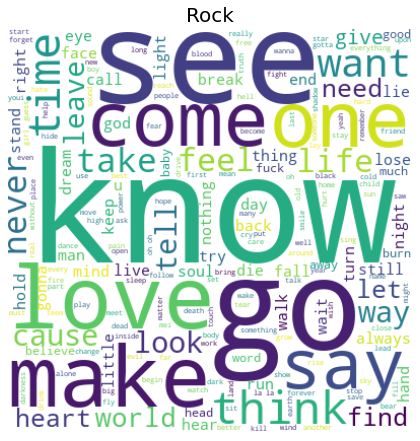

In [28]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(rock)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Rock', size=20)

The first method for feature extraction used was TF-ID Vectorizer from sklearn. This method was used for all sklearn algorithms. The vectorizer was applied on both the train and test data because in order to predict on the test data, the algorithms need the same number of features as input. After feature extraction the train and test data were split.

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=10)
train_data = data['new']
test_data = test['new']
all_data = train_data.append(test_data)
features = vectorizer.fit_transform(all_data).toarray()
X = features[:18513]
X_test = features[18513:]
print(features.shape)

(26448, 29016)


The train set was split into train and validation with a ratio of 95-5.

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, data.label,test_size = 0.05)

In [ ]:
Logistic Regression Validation Results

e:\nlp2\venv\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.49892008639308855
926


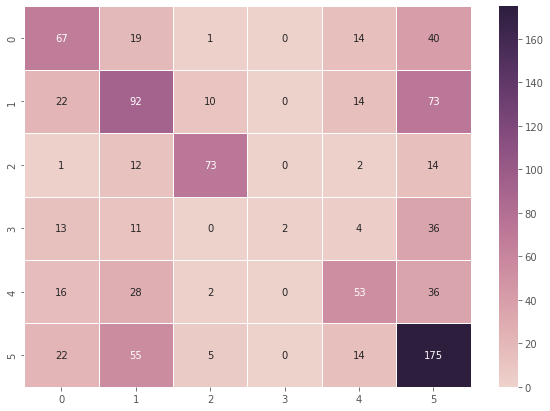

In [31]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_predicted = lr.predict(X_valid)
score = lr.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Logistic Regression Test Results

0.49262759924385635
7935


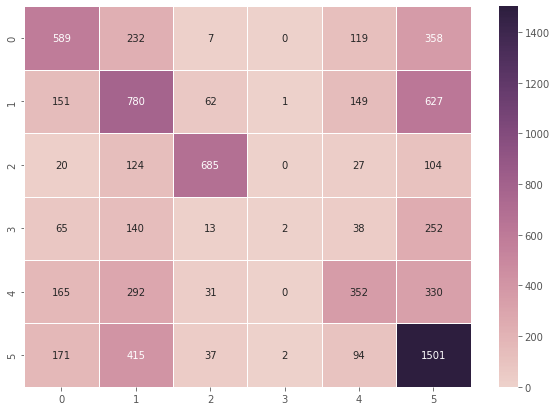

In [32]:
y_test = test.label
predicted = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Bernoulli NB Validation Results

0.5010799136069114
926


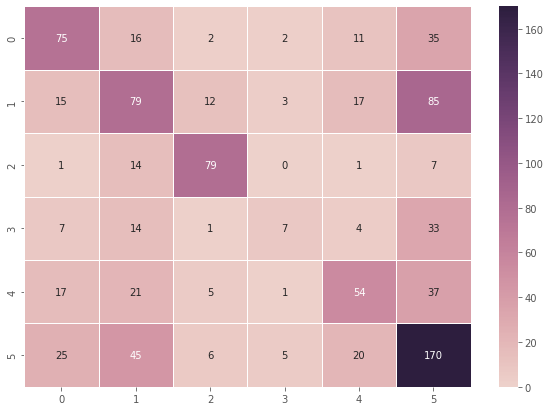

In [33]:
brn = BernoulliNB()
brn.fit(X_train, y_train)
y_predicted = brn.predict(X_valid)
score = brn.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Bernoulli NB Test Results

0.5004410838059231
7935


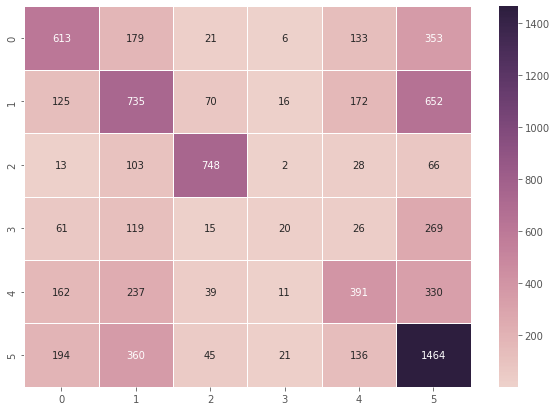

In [34]:
y_test = test.label
predicted = brn.predict(X_test)
score = brn.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Multinomial NB Validation Results

0.4298056155507559
926


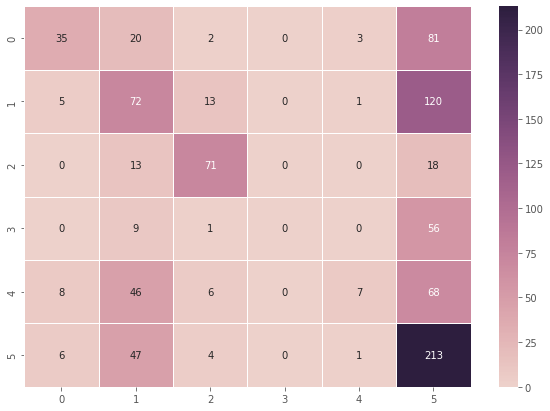

In [35]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_valid)
score = clf.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Multinomial NB Test Results

0.4509136735979836
7935


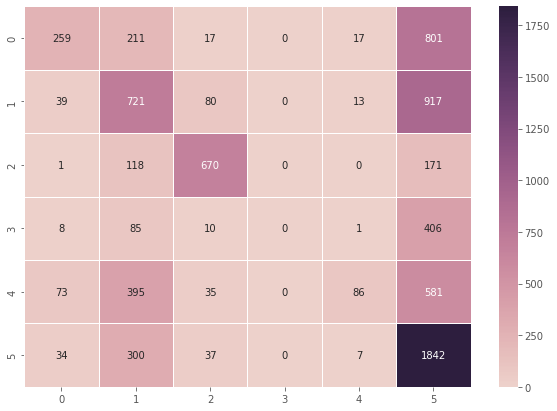

In [36]:
y_test = test.label
predicted = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

LinearSVC Validation Results

0.46976241900647947
926


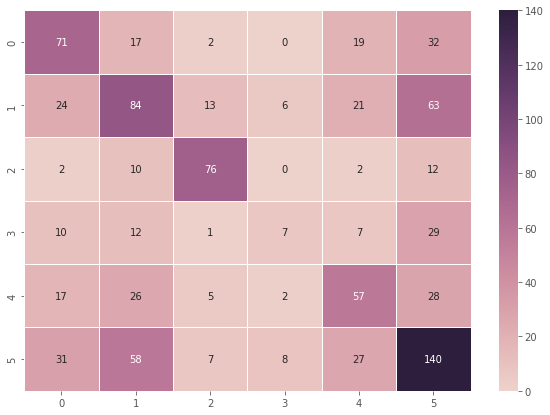

In [37]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_valid)
score = clf.score(X_valid,y_valid)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_valid, y_predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_valid, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

LinearSVC Test Results

0.4657844990548204
7935


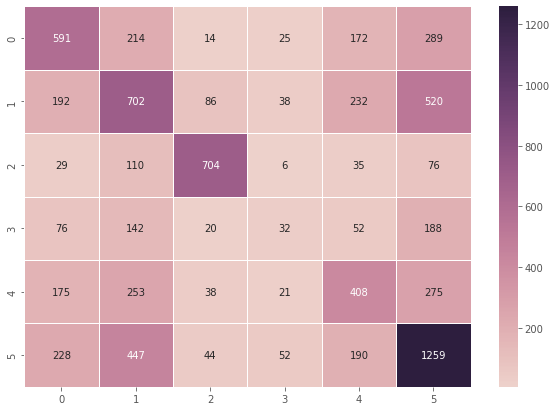

In [38]:
y_test = test.label
predicted = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score)
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
print(sum(sum(confusion_matrix(y_test, predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

The second method used was Tokenizer from Keras. All the text is tokenized and a vocabulary is created based on word frequency. the most used word will have the index 1, as 0 is kept for padding. Then each row of the dataframe is turned into a sequence. This means that instead of having the format word1 word2 word3 etc. it will have the format index of word1 index of word2 index of word3 etc. Next we find the maximum length of a sequence in order to use it for padding.

In [39]:
#Sequence + tokanization 
all_data = []
train_data = data['new']
test_data = test['new']
all_data = train_data.append(test_data)
y= data['label']
num_words = all_data.shape[0]
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(all_data)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(all_data)
length=[]
for i in sequences:
    length.append(len(i))
print("Max is: ",np.max(length))

Max is:  966


All sequences are padded to the maximum length in order to be able to input them into the models.

In [40]:
sequences = pad_sequences(sequences, padding = 'post')
X = sequences[:18513]
X_test = sequences[18513:]

Data is split into train and validation.

In [41]:
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.05)

First model is simple LSTM. The optimizer is Adam and the loss function is Sparse Categorical Crossentropy.

In [186]:
#model
def build_model(nr_labels, length):
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length = length))
    model.add(LSTM(32, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nr_labels, activation='sigmoid'))
    return model

def build_compiled_model(length):
    model = build_model(nr_labels=6, length = length)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_compiled_model(np.max(length))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 966, 32)           846336    
                                                                 
 lstm_8 (LSTM)               (None, 966, 32)           8320      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_48 (Dense)            (None, 64)                2112      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 6)                 390       
                                                     

In [187]:
#train model
history = model.fit(x=x_train, y=y_train, epochs=3, validation_data=(x_valid, y_valid), shuffle=True)

Epoch 1/3
550/550 [==============================] - 17s 29ms/step - loss: 1.5701 - accuracy: 0.3406 - val_loss: 1.4954 - val_accuracy: 0.3877
Epoch 2/3
550/550 [==============================] - 15s 28ms/step - loss: 1.3829 - accuracy: 0.4442 - val_loss: 1.4037 - val_accuracy: 0.4330
Epoch 3/3
550/550 [==============================] - 15s 28ms/step - loss: 1.1422 - accuracy: 0.5807 - val_loss: 1.4052 - val_accuracy: 0.4579


In [188]:
#make predictions
y_pred = np.argmax(model.predict(x_valid), axis=1)

LSTM Validation Results

On validation data:
Accuracy: 0.46


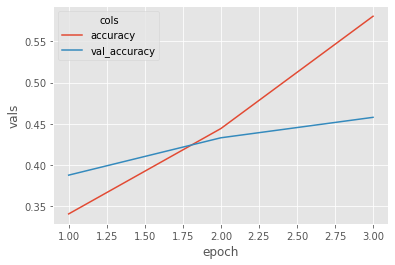

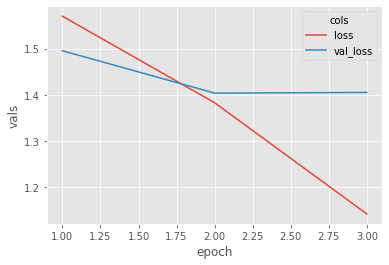

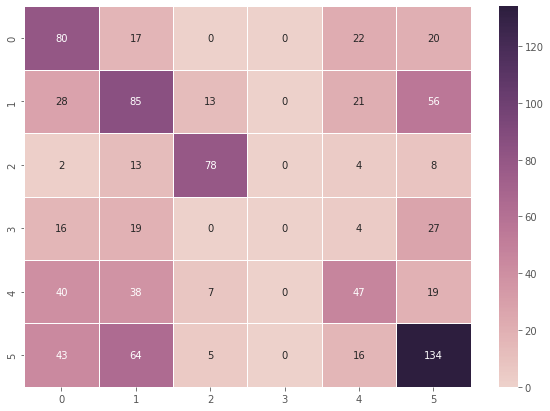

In [189]:
print('On validation data:')
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

# plot graphs
metrics_df = pd.DataFrame(history.history).reset_index().rename(columns={"index": "epoch"})
metrics_df['epoch'] = metrics_df['epoch'] + 1
acc_df = metrics_df[['epoch', 'accuracy', 'val_accuracy']].melt('epoch', var_name='cols', value_name='vals')
loss_df = metrics_df[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='cols', value_name='vals')
sns.lineplot(data=acc_df, x='epoch', y='vals', hue='cols')
plt.show()
sns.lineplot(data=loss_df, x='epoch', y='vals', hue='cols')
plt.show()

# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

LSTM Test Results

In [190]:
y_test = test['label']

In [191]:
pred = np.argmax(model.predict(X_test), axis=1)

On test data:
Accuracy: 0.47


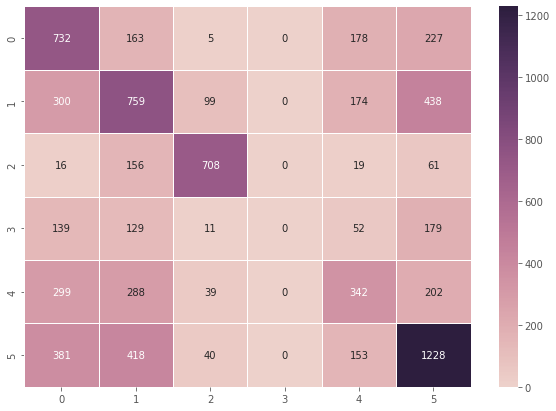

In [192]:
print('On test data:')
print('Accuracy: %.2f' % accuracy_score(y_test, pred))
# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

The second model is a CNN. Optimizer is Adam and loss function is Sparse Categorical Crossentropy.

In [199]:
def build_model(nr_labels, length):
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length = length))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPool1D(5))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPool1D(5))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPool1D(5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nr_labels, activation='softmax'))

    return model

def build_compiled_model(length):
    model = build_model(nr_labels=6, length = length)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_compiled_model(np.max(length))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 966, 32)           846336    
                                                                 
 conv1d_54 (Conv1D)          (None, 962, 128)          20608     
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 192, 128)         0         
 g1D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 192, 128)          0         
                                                                 
 conv1d_55 (Conv1D)          (None, 188, 256)          164096    
                                                                 
 max_pooling1d_55 (MaxPoolin  (None, 37, 256)          0         
 g1D)                                                

In [200]:
#train model
history = model.fit(x=x_train, y=y_train, epochs=3, validation_data=(x_valid, y_valid), shuffle=True)

Epoch 1/3
550/550 [==============================] - 7s 12ms/step - loss: 1.5186 - accuracy: 0.3687 - val_loss: 1.5113 - val_accuracy: 0.3618
Epoch 2/3
550/550 [==============================] - 6s 11ms/step - loss: 1.3882 - accuracy: 0.4406 - val_loss: 1.4401 - val_accuracy: 0.4071
Epoch 3/3
550/550 [==============================] - 6s 11ms/step - loss: 1.1488 - accuracy: 0.5579 - val_loss: 1.4738 - val_accuracy: 0.4417


In [201]:
#make predictions
y_pred = np.argmax(model.predict(x_valid), axis=1)

CNN Validation Results

On validation data:
Accuracy: 0.44


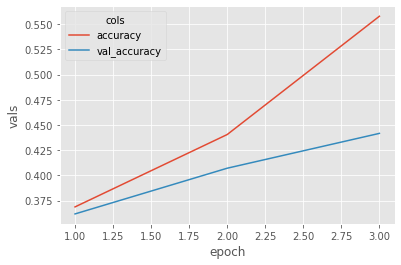

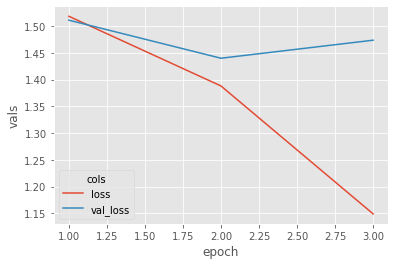

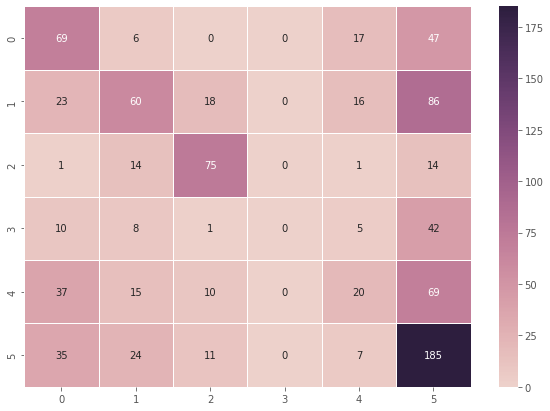

In [202]:
print('On validation data:')
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

# plot graphs
metrics_df = pd.DataFrame(history.history).reset_index().rename(columns={"index": "epoch"})
metrics_df['epoch'] = metrics_df['epoch'] + 1
acc_df = metrics_df[['epoch', 'accuracy', 'val_accuracy']].melt('epoch', var_name='cols', value_name='vals')
loss_df = metrics_df[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='cols', value_name='vals')
sns.lineplot(data=acc_df, x='epoch', y='vals', hue='cols')
plt.show()
sns.lineplot(data=loss_df, x='epoch', y='vals', hue='cols')
plt.show()

# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

CNN Test Results

In [203]:
pred = np.argmax(model.predict(X_test), axis=1)

On test data:
Accuracy: 0.44


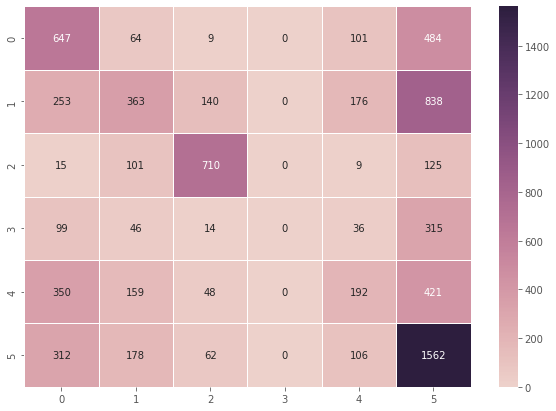

In [204]:
print('On test data:')
print('Accuracy: %.2f' % accuracy_score(y_test, pred))
# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index=[0,1,2,3,4,5], columns=[0,1,2,3,4,5])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()